In [1]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set_style("ticks")
%matplotlib inline

In [2]:
bcdr_d0G_med = pd.read_csv('../data/clean/bcdr_d0G_med.csv')
bcdr_d0G_med.head()

,i_mean,i_std_dev,i_maximum,i_minimum,i_kurtosis,i_skewness,s_area,s_perimeter,s_x_center_mass,s_y_center_mass,...,t_homo,t_savgh,t_svarh,t_senth,t_entro,t_dvarh,t_denth,t_inf1h,t_inf2h,classification
0,0.85478,0.096944,1.00000,0.54118,-0.98733,-0.14516,35215,881.5778,0.13751,0.28846,...,0.52281,55.3474,2771.1561,3.0068,4.3143,3.9515,1.5656,-0.190550,0.77071,Malign
1,0.83313,0.119880,1.00000,0.37647,-0.05923,-0.64293,52898,1423.0723,0.21043,0.42407,...,0.46888,54.2754,2654.1706,3.1893,4.7304,6.7713,1.8039,-0.149960,0.72962,Malign
2,0.55903,0.070948,1.00000,0.34510,4.94010,1.20480,5957,300.4924,0.22107,0.76640,...,0.48007,36.5319,1166.2156,2.5313,4.0464,5.9552,1.7124,-0.028458,0.32486,Benign
3,0.75233,0.094601,1.00000,0.47059,0.12929,0.22278,8439,364.9605,0.22980,0.49920,...,0.43897,48.3651,2081.4079,3.0147,4.6922,7.3839,1.8264,-0.081846,0.57253,Benign
4,0.58568,0.069084,0.90196,0.32157,0.98535,0.28343,6179,327.4630,0.14915,0.23309,...,0.44106,38.5474,1306.9212,2.5311,4.2309,7.7829,1.8325,-0.024156,0.27899,Benign


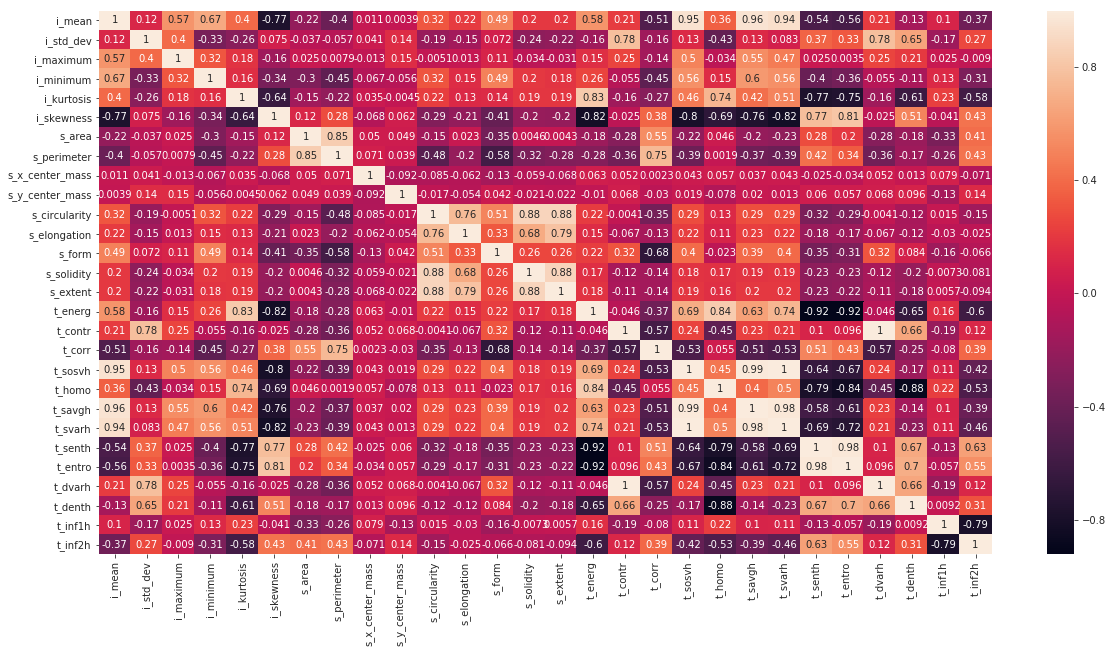

In [3]:
plt.figure(figsize=(20,10))
sns.heatmap(bcdr_d0G_med.corr(), annot=True)

In [4]:
bcdr_d0G_med['classification'] = bcdr_d0G_med['classification'].astype(str)
bcdr_d0G_med['diagnosis'] = [1 if x.strip() == 'Malign' else 0 for x in bcdr_d0G_med['classification']] 
bcdr_d0G_med = bcdr_d0G_med.drop(columns=['classification']) 
bcdr_d0G_med.to_csv('../data/clean/bcdr_d0G_medc.csv', index=False)
print(bcdr_d0G_med.shape)

(598, 29)


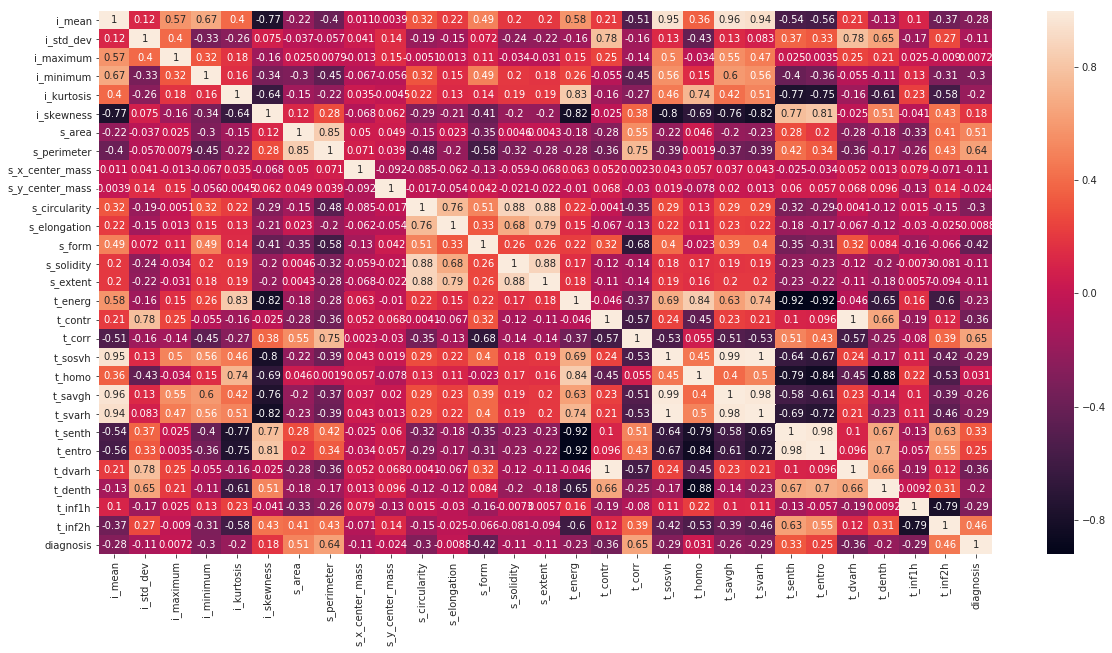

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(bcdr_d0G_med.corr(), annot=True)
plt.savefig('fig_01.png')

## Feature selection using P-value

In [6]:
from sklearn import preprocessing
from scipy.stats import zscore

data = bcdr_d0G_med
data_ = data.diagnosis
data = data.drop(columns=['diagnosis'])
data = data.apply(zscore)

# Correlation metrics
label_encoder = LabelEncoder()
data.iloc[:,data.shape[1] - 1] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
corr = data.corr()
#sns.heatmap(corr)


# Next, we compare the correlation between features 
# and remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

# pvalue feature selection
selected_columns = selected_columns[1:].values

import statsmodels.formula.api as sm

def backward_elimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

data_modeled, selected_columns = backward_elimination(data.iloc[:,1:].values, data.iloc[:,0].values,0.05, selected_columns)

# Moving the result to a new Dataframe
result = pd.DataFrame()
result['diagnosis'] = data_

# Creating a Dataframe with the columns selected using the p-value and correlation
fs_data = pd.DataFrame(data = data_modeled, columns = selected_columns)

In [7]:
fs_data.head()

,i_std_dev,i_maximum,i_minimum,i_kurtosis,i_skewness,s_area,s_perimeter,s_y_center_mass,s_elongation,s_form,s_solidity,t_energ,t_contr,t_senth,t_denth,t_inf1h
0,-0.362641,0.377486,1.016310,-0.672415,0.302148,-0.016982,0.418141,-1.529244,-0.297228,-0.879659,-0.474621,-0.488533,-0.821699,0.577464,-0.499107,-0.743223
1,0.219648,0.377486,-0.070770,-0.481494,-0.027950,0.160994,1.127052,-0.557157,-0.139873,-0.854139,-2.029973,-0.508992,-0.665230,0.826237,-0.023137,-0.296877
2,-1.022615,0.377486,-0.277810,0.546929,1.197380,-0.311458,-0.342601,1.896751,0.051231,-0.636728,0.639300,-0.446818,-0.710515,-0.070710,-0.205895,1.039213
3,-0.422124,0.377486,0.550419,-0.442713,0.546149,-0.286478,-0.258201,-0.018606,-0.470087,-0.757824,0.654583,-0.512069,-0.631238,0.588233,0.021803,0.452134
4,-1.069938,-0.577900,-0.433108,-0.266611,0.586369,-0.309224,-0.307292,-1.926150,-0.469614,-0.686496,0.464135,-0.468354,-0.609097,-0.070982,0.033987,1.086519


## Feature selection using P-value (form 2) 

In [8]:
results = sm.OLS(bcdr_d0G_med.diagnosis, bcdr_d0G_med.drop(columns=['diagnosis'])).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     47.65
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          2.23e-127
Time:                        15:55:39   Log-Likelihood:                 18.671
No. Observations:                 598   AIC:                             16.66
Df Residuals:                     571   BIC:                             135.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
i_mean             -1.5648      0.440     

In [9]:
fs_data.to_csv('../data/clean/fs_data.csv', index=False)

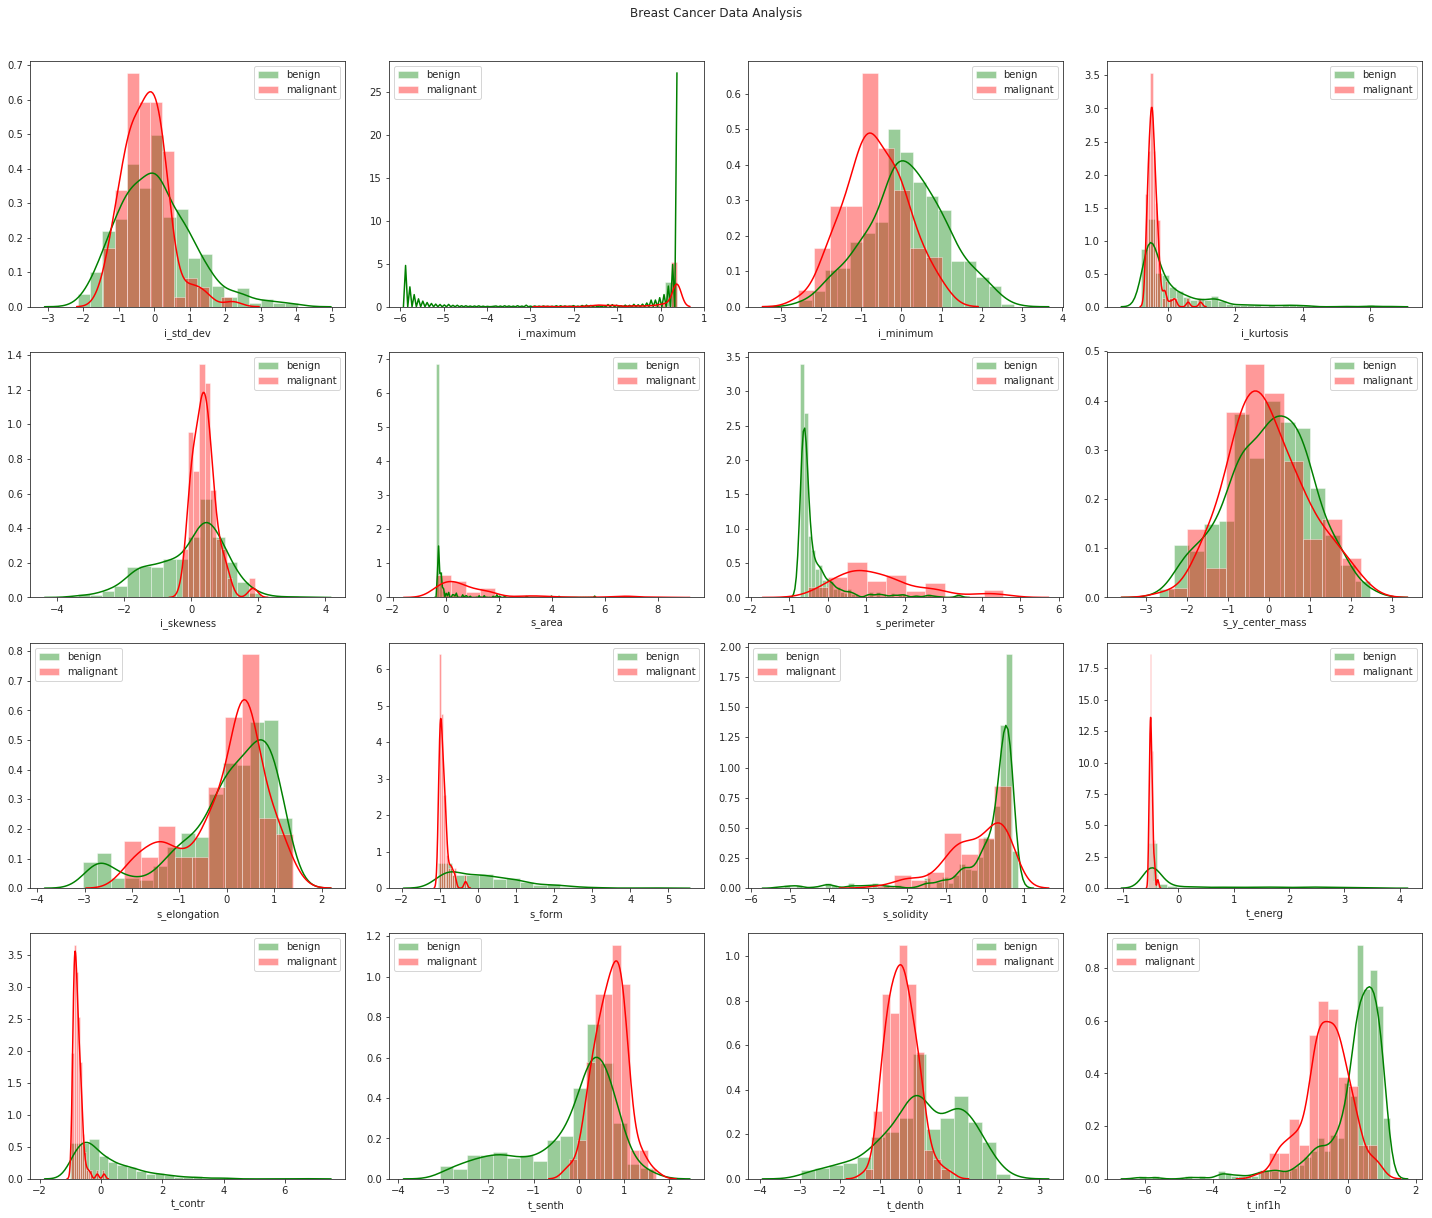

In [10]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (20, 25))
j = 0
for i in fs_data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(fs_data[i][bcdr_d0G_med['diagnosis']==0], color='g', label = 'benign')
    sns.distplot(fs_data[i][bcdr_d0G_med['diagnosis']==1], color='r', label = 'malignant')
    plt.legend(loc='best')
fig.suptitle('Breast Cancer Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('fig_02.png')
plt.show()


## Univariate Selection

[ 0.01216464  0.01619671  0.01588179  0.02641897  0.0136397   0.03233592
  0.03719767  0.20448861  0.0275384   0.01412493  0.02104951  0.01974434
  0.05315703  0.02346793  0.01637196  0.01781219  0.04875086  0.13216548
  0.0253762   0.02697296  0.018146    0.01453346  0.00915405  0.02277078
  0.01330257  0.02489605  0.06160659  0.05073467]


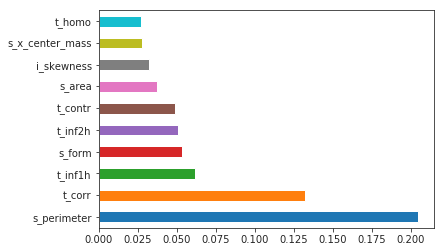

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = bcdr_d0G_med.iloc[:,0:bcdr_d0G_med.shape[1] - 1]
y = bcdr_d0G_med.diagnosis    #target column i.e price range

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()